<a href="https://colab.research.google.com/github/ever-oli/MLby22/blob/main/catsvsdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training on device: cuda

Loading microsoft/cats_vs_dogs dataset from Hugging Face...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

Training samples: 18728 | Validation samples: 4682

Calculating class weights for imbalance handling...
Class Weights: {0: 0.9955347650435892, 1: 1.0045054709289851}

Starting Training...

Epoch 1/5 | Train Loss: 0.6213 Acc: 0.6444 | Val Loss: 0.5516 Acc: 0.7187
Epoch 2/5 | Train Loss: 0.5257 Acc: 0.7388 | Val Loss: 0.4828 Acc: 0.7631
Epoch 3/5 | Train Loss: 0.4602 Acc: 0.7874 | Val Loss: 0.4483 Acc: 0.7868
Epoch 4/5 | Train Loss: 0.4247 Acc: 0.8078 | Val Loss: 0.4031 Acc: 0.8223
Epoch 5/5 | Train Loss: 0.3931 Acc: 0.8245 | Val Loss: 0.3736 Acc: 0.8306

Generating Loss and Accuracy plots...


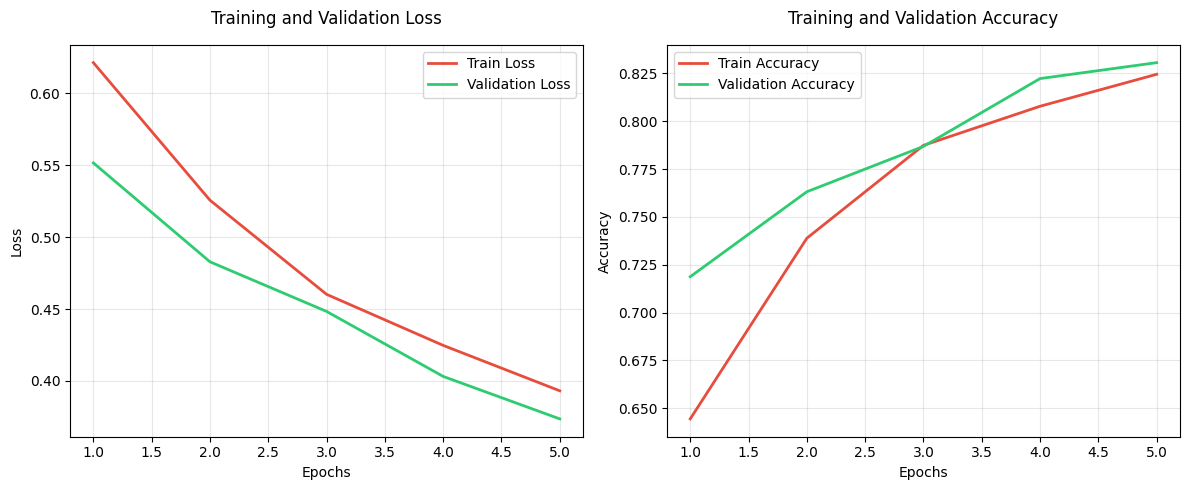

In [1]:

# CNN IMAGE CLASSIFICATION: CATS VS DOGS

# !pip install datasets torch torchvision matplotlib numpy -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}\n")


# 1. Data Loading via Hugging Face

print("Loading microsoft/cats_vs_dogs dataset from Hugging Face...")
# The dataset has a 'train' split. We will load it and split it ourselves.
dataset = load_dataset("microsoft/cats_vs_dogs", split="train")

# Split into 80% training and 20% validation
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_data = dataset['train']
val_data = dataset['test']

print(f"Training samples: {len(train_data)} | Validation samples: {len(val_data)}\n")


# 2. Data Augmentation and Pre-processing

# Data augmentation prevents overfitting by artificially expanding the dataset
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation only needs resizing and normalization, NO augmentation
val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom PyTorch Dataset to wrap the Hugging Face dataset
class HFVisionDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image'].convert("RGB") # Ensure 3 channels
        label = item['labels']

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = HFVisionDataset(train_data, transform=train_transforms)
val_dataset = HFVisionDataset(val_data, transform=val_transforms)


# 3. Handling Class Imbalances

print("Calculating class weights for imbalance handling...")
# Extract all labels to calculate frequency
train_labels = [item['labels'] for item in train_data]
class_counts = Counter(train_labels)
num_samples = len(train_labels)

# Calculate weight for each class: Total / (Number of classes * Count of specific class)
class_weights = {cls: num_samples / (len(class_counts) * count) for cls, count in class_counts.items()}
print(f"Class Weights: {class_weights}")

# Convert weights to tensor for the Loss Function
weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)


# 4. DataLoaders

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


# 5. Convolutional Neural Network (CNN) Architecture

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully Connected Classifier
        self.flatten = nn.Flatten()
        # After three 2x2 poolings, the 128x128 image becomes 16x16
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2) # 2 output classes

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

# Loss function with the calculated class weights to penalize majority class bias
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 6. Training Loop

epochs = 5 # Kept short for Colab demonstration
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting Training...\n")
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation Phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / total
    epoch_val_acc = correct / total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")


# 7. Plotting the Learning Curves

print("\nGenerating Loss and Accuracy plots...")
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='#e74c3c', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='#2ecc71', linewidth=2)
plt.title('Training and Validation Loss', pad=15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accs, label='Train Accuracy', color='#e74c3c', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, label='Validation Accuracy', color='#2ecc71', linewidth=2)
plt.title('Training and Validation Accuracy', pad=15)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [2]:

# 5. Transfer Learning Architecture (ResNet18)

import torchvision.models as models

print("Loading pre-trained ResNet18 model...")

# Load the ResNet18 model with the best available pre-trained ImageNet weights
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

# Freeze all existing layers in the network.
# We do this so the pre-trained weights are not destroyed by large gradient
# updates during the first few epochs of training.
for param in model.parameters():
    param.requires_grad = False

# ResNet18's final fully connected layer outputs 1000 classes (ImageNet).
# We must replace it with a new layer that outputs our 2 classes (Cats vs Dogs).
# By default, newly created layers have requires_grad=True.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Loss function with the calculated class weights
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Optimizer setup:
# Notice we are ONLY passing the parameters of the newly created fc layer to the optimizer,
# rather than model.parameters(), because the rest of the network is frozen.
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print("Architecture updated to ResNet18. Ready for training.")

Loading pre-trained ResNet18 model...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 42.1MB/s]


Architecture updated to ResNet18. Ready for training.



Starting Transfer Learning Training...

Epoch 01/05 | Train Loss: 0.2330 Acc: 0.8998 | Val Loss: 0.1664 Acc: 0.9284
Epoch 02/05 | Train Loss: 0.1864 Acc: 0.9210 | Val Loss: 0.1786 Acc: 0.9238
Epoch 03/05 | Train Loss: 0.1782 Acc: 0.9236 | Val Loss: 0.1577 Acc: 0.9312
Epoch 04/05 | Train Loss: 0.1732 Acc: 0.9295 | Val Loss: 0.1568 Acc: 0.9336
Epoch 05/05 | Train Loss: 0.1691 Acc: 0.9287 | Val Loss: 0.1533 Acc: 0.9331

Generating Loss and Accuracy plots...


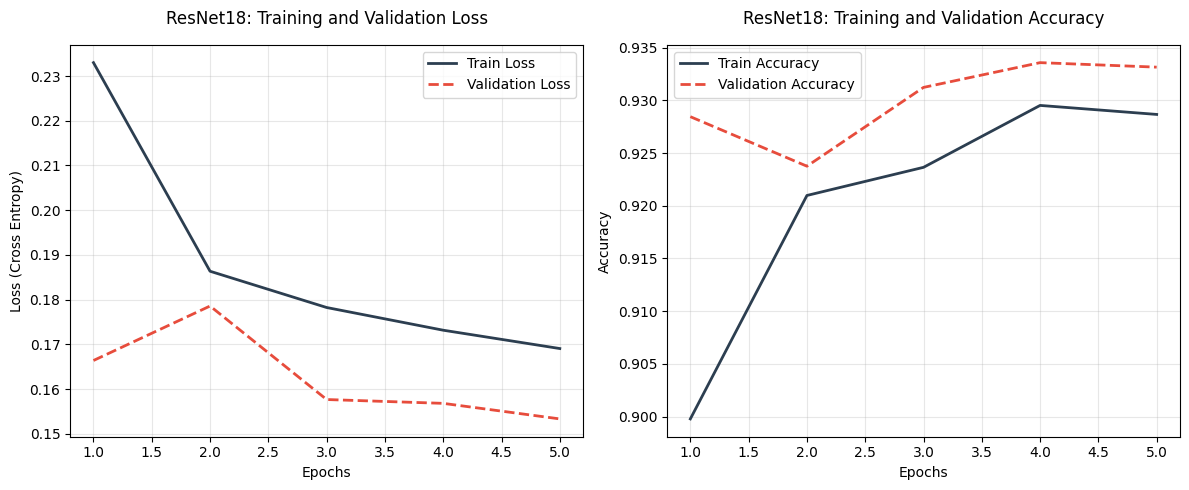


Model evaluation complete. Look for convergence between the train and validation lines.


In [3]:

# 6. Training Loop (Transfer Learning)

epochs = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting Transfer Learning Training...\n")
for epoch in range(epochs):
    # Set model to training mode (enables dropout, batchnorm updates)
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation Phase
    # Set model to evaluation mode (disables dropout, uses population statistics for batchnorm)
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    # Disable gradient calculation for validation to save memory and compute
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / total
    epoch_val_acc = correct / total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch+1:02d}/{epochs:02d} | "
          f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")


# 7. Plotting the Learning Curves

print("\nGenerating Loss and Accuracy plots...")
plt.figure(figsize=(12, 5))

# Plot 1: Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', color='#2c3e50', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='#e74c3c', linewidth=2, linestyle='--')
plt.title('ResNet18: Training and Validation Loss', pad=15)
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accs, label='Train Accuracy', color='#2c3e50', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, label='Validation Accuracy', color='#e74c3c', linewidth=2, linestyle='--')
plt.title('ResNet18: Training and Validation Accuracy', pad=15)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nModel evaluation complete. Look for convergence between the train and validation lines.")